<a href="https://colab.research.google.com/github/drashyabansel/GenerativeAI/blob/main/Working_with_AutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
from datasets import load_dataset

mnist = load_dataset("mnist")
mnist

README.md:   0%|          | 0.00/6.97k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [ ]:
mnist["train"]["image"][1]

In [ ]:
from torchvision import transforms
import torch

torch.manual_seed(6)

def mnist_to_tensor(samples):
  t = transforms.ToTensor()
  samples["image"] = [t(image) for image in samples["image"]]
  return samples


In [ ]:
mnist = mnist.with_transform(mnist_to_tensor)
mnist["train"] = mnist["train"].shuffle(seed=6)

In [ ]:
x = mnist["train"]["image"][0]
x.min(), x.max()

(tensor(0.), tensor(1.))

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(mnist["train"]["image"], batch_size=64)

In [ ]:
from torch import nn

def conv_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
  return nn.Sequential(
      nn.Conv2d(
          in_channels,
          out_channels,
          kernel_size=kernel_size,
          stride=stride,
          padding=padding
        ),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
  )

In [ ]:
class Encoder(nn.Module):
  def __init__(self, in_channels):
    super().__init__()
    self.conv1 = conv_block(in_channels=in_channels, out_channels=128)
    self.conv2 = conv_block(in_channels=128, out_channels=256)
    self.conv3 = conv_block(in_channels=256, out_channels=512)
    self.conv4 = conv_block(in_channels=512, out_channels=1024)
    self.linear = nn.Linear(1024, 16)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.linear(x.flatten(start_dim=1))
    return x

In [ ]:
mnist['train']['image'][0].shape

torch.Size([1, 28, 28])

In [ ]:
input_channel = 1

x = mnist['train']['image'][0][None, : ]
x.shape

torch.Size([1, 1, 28, 28])

In [ ]:
encoder = Encoder(in_channels=input_channel).eval()
encoded = encoder(x)
encoded.shape

torch.Size([1, 16])

In [ ]:
encoded

tensor([[ 0.0058, -0.0070,  0.0093,  0.0103,  0.0354, -0.0044, -0.0068,  0.0305,
         -0.0318, -0.0321, -0.0133,  0.0074, -0.0420,  0.0335,  0.0105, -0.0252]],
       grad_fn=<AddmmBackward0>)

In [ ]:
batch = next(iter(train_dataloader))
encoded = Encoder(in_channels=1)(batch)
batch.shape, encoded.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 16]))

In [ ]:
def conv_transpose_block(
    in_channels,
    out_channels,
    kernel_size=3,
    stride=2,
    padding=1,
    output_padding=0,
    with_act = True
):
  modules = [
      nn.ConvTranspose2d(
          in_channels,
          out_channels,
          kernel_size=kernel_size,
          stride=stride,
          padding=padding,
          output_padding=output_padding
      ),
  ]
  if with_act:
    modules.append(nn.BatchNorm2d(out_channels))
    modules.append(nn.ReLU())
  return nn.Sequential(*modules)

In [ ]:
class Decoder(nn.Module):
  def __init__(self, out_channels):
    super().__init__()

    self.linear = nn.Linear(
        16, 1024 * 4 * 4
    )
    self.t_conv1 = conv_transpose_block(1024, 512)
    self.t_conv2 = conv_transpose_block(512, 256, output_padding=1)
    self.t_conv3 = conv_transpose_block(256, 128, output_padding=1)

  def forward(self, x):
    batch_size = x.shape[0]
    x = self.linear(x)
    x = x.reshape(batch_size, 1024, 4, 4)
    x = self.t_conv1(x)
    x = self.t_conv2(x)
    x = self.t_conv3(x)
    return x


In [ ]:
decoded_batch = Decoder(x.shape[0])(encoded)
decoded_batch.shape

torch.Size([64, 128, 28, 28])

In [ ]:
class AutoEncoder(nn.Module):
  def __init__(self, in_channels):
    super().__init__()
    self.encoder = Encoder(in_channels=in_channels)
    self.decoder = Decoder(out_channels=in_channels)

  def encode(self, x):
    return self.encoder(x)

  def decode(self, x):
    return self.decoder(x)

  def forward(self, x):
    return self.decode(self.encode(x))

model = AutoEncoder(in_channels=1)

In [ ]:
import torchsummary

torchsummary.summary(model, input_size=(1, 28, 28), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 14, 14]           2,176
       BatchNorm2d-2          [-1, 128, 14, 14]             256
              ReLU-3          [-1, 128, 14, 14]               0
            Conv2d-4            [-1, 256, 7, 7]         524,544
       BatchNorm2d-5            [-1, 256, 7, 7]             512
              ReLU-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 3, 3]       2,097,664
       BatchNorm2d-8            [-1, 512, 3, 3]           1,024
              ReLU-9            [-1, 512, 3, 3]               0
           Conv2d-10           [-1, 1024, 1, 1]       8,389,632
      BatchNorm2d-11           [-1, 1024, 1, 1]           2,048
             ReLU-12           [-1, 1024, 1, 1]               0
           Linear-13                   [-1, 16]          16,400
          Encoder-14                   

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch.nn import functional as F
from tqdm.notebook import tqdm, trange

In [ ]:
num_epochs = 10
lr_rate = 1e-4

model = model.to("cuda")
optimizer = torch.optim.AdamW(model.parameters(), lr=lr_rate, eps=1e-5)

losses = []

In [ ]:
for _ in (progress := trange(num_epochs, desc="Training")):
  for _, batch in (inner := tqdm(enumerate(train_dataloader), total=len(train_dataloader))):
    batch = batch.to("cuda")

    preds = model(batch)

    loss = F.mse_loss(preds, batch)

    inner.set_postfix(loss=f"{loss.cpu().item():.3f}")
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  progress.set_postfix(loss=f"{loss.cpu().item():3f}", lr=f"{lr_rate:.0e}")

Training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

<ipython-input-23-a564a5afe6dc>:7: UserWarning: Using a target size (torch.Size([64, 1, 28, 28])) that is different to the input size (torch.Size([64, 128, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(preds, batch)
<ipython-input-23-a564a5afe6dc>:7: UserWarning: Using a target size (torch.Size([32, 1, 28, 28])) that is different to the input size (torch.Size([32, 128, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(preds, batch)


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

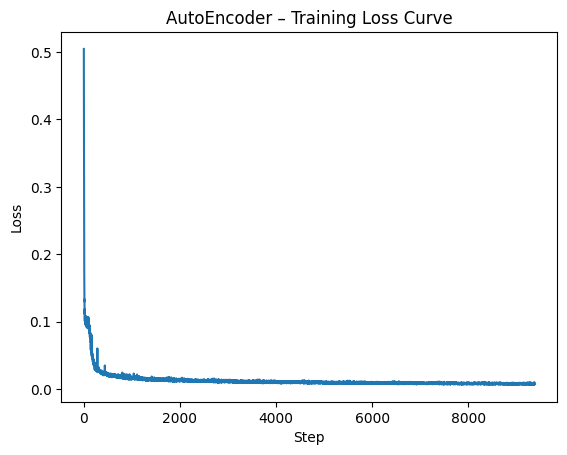

In [ ]:
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("AutoEncoder – Training Loss Curve")
plt.show()

In [ ]:
eval_batch_size = 16

eval_dataloader = DataLoader(mnist["test"]["image"], batch_size=eval_batch_size)

In [ ]:
model.eval()

with torch.inference_mode():
  eval_batch = next(iter(eval_dataloader))
  predicted = model(eval_batch.to("cuda")).cpu()

In [ ]:
eval_batch.shape

torch.Size([16, 1, 28, 28])

In [ ]:
predicted.shape

torch.Size([16, 128, 28, 28])

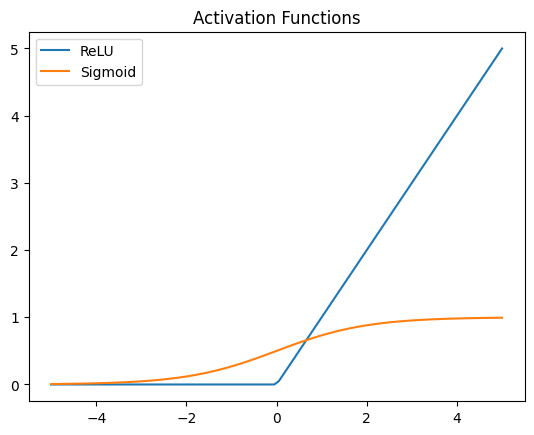

In [ ]:
def plot_activation_fn(fn, name):
    x = torch.linspace(-5, 5, 100)
    y = fn(x)
    plt.plot(x, y, label=name)
    plt.legend()


plt.title("Activation Functions")
plot_activation_fn(F.relu, "ReLU")
plot_activation_fn(F.sigmoid, "Sigmoid")

In [ ]:
class Encoder(nn.Module):
  def __init__(self, in_channels, latent_dimension):
    super().__init__()
    self.conv_layer = nn.Sequential(
        conv_block(in_channels, 128),
        conv_block(128, 256),
        conv_block(256, 512),
        conv_block(512, 1024),
    )
    self.linear = nn.Linear(1024, latent_dimension)

  def forward(self, x):
    bs = x.shape[0]
    x = self.conv_layer(x)
    x = self.linear(x.reshape(bs, -1))
    return x


In [ ]:
class Decoder(nn.Module):
  def __init__(self, out_channel, latent_dimension):
    super().__init__()

    self.linear = nn.Linear(latent_dimension, 1024*4*4)
    self.t_conv_layer = nn.Sequential(
        conv_transpose_block(1024, 512),
        conv_transpose_block(512, 256, output_padding=1),
        conv_transpose_block(256, out_channel, output_padding=1, with_act=False),
    )
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    bs = x.shape[0]
    x = self.linear(x)
    x = x.reshape(bs, 1024, 4, 4)
    x = self.t_conv_layer(x)
    x = self.sigmoid(x)
    return x


In [ ]:
class AutoEncoder(nn.Module):
  def __init__(self, in_channels, latent_dimension):
    super().__init__()
    self.encoder = Encoder(in_channels=in_channels, latent_dimension=latent_dimension)
    self.decoder = Decoder(out_channel=in_channels, latent_dimension=latent_dimension)

  def encode(self, x):
    return self.encoder(x)

  def decode(self, x):
    return self.decoder(x)

  def forward(self, x):
    return self.decode(self.encode(x))

In [ ]:
device = "cuda"

def train(model, num_epochs=10, lr=1e-4):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)

    model.train()  # Put model in training mode
    losses = []
    for _ in (progress := trange(num_epochs, desc="Training")):
        for _, batch in (
            inner := tqdm(
                enumerate(train_dataloader), total=len(train_dataloader)
            )
        ):
            batch = batch.to(device)

            # Pass through the model and obtain another set of images
            preds = model(batch)

            # Compare the prediction with the original images
            loss = F.mse_loss(preds, batch)

            # Display loss and store for plotting
            inner.set_postfix(loss=f"{loss.cpu().item():.3f}")
            losses.append(loss.item())

            # Update the model parameters with the optimizer based on this loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        progress.set_postfix(loss=f"{loss.cpu().item():.3f}", lr=f"{lr:.0e}")
    return losses

In [ ]:
ae_model = AutoEncoder(in_channels=1, latent_dimension=2)
ae_model.to(device)

AutoEncoder(
  (encoder): Encoder(
    (conv_layer): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): Sequential(
        (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (linear): Linear(in_f

In [ ]:
losses = train(ae_model)

Training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

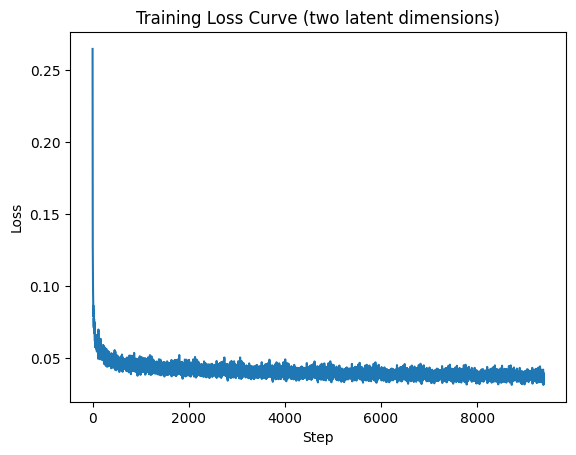

In [ ]:
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve (two latent dimensions)")
plt.show()

In [ ]:
ae_model.eval()
with torch.inference_mode():
    eval_batch = next(iter(eval_dataloader))
    predicted = ae_model(eval_batch.to(device)).cpu()

In [ ]:
batch_vs_preds = torch.cat((eval_batch, predicted))